In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import cmocean.cm as cmo
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
import geopandas as gpd
import geospatial_utils
from shapely.geometry import box

local_crs = 3106 # Bangladesh crs in metres

wd = os.path.join('..')
datadir = os.path.join(wd, 'sample_data')
bathypath = os.path.join(datadir, 'gebco_bay_of_bengal.nc')
windpath = os.path.join(datadir, 'era5_bangladesh_2021.nc')
outdir = datadir

# Developing code to extract grids from shapefiles and NetCDFs
This code loads NetCDF files and shapefiles, defines a grid by width, height, meshsize, and rotation, and extracts the zonal statistics over that grid.

In [2]:
# wind_ds = xr.open_dataset(windpath)
# wind_ds = wind_ds.where(wind_ds['time']==time, drop=True)
# wind_ds.to_netcdf(windpath)

In [46]:
# grid config
mesh = 30_000
centroid = [93.2, 18.4]
rotation = 45
width, height = 200_000, 400_000

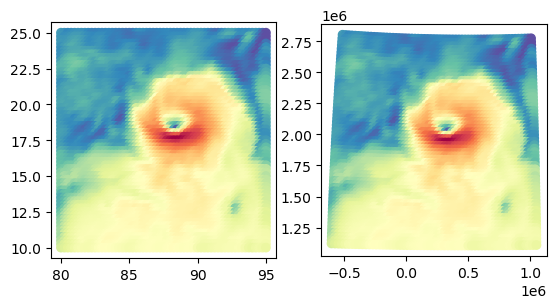

In [47]:
# load dataframe from NetCDF file
df_wind = geospatial_utils.xarray_to_geopandas_with_time(windpath, xvar='longitude', yvar='latitude', var=['u10', 'v10'])
df_wind['time'] = pd.to_datetime(df_wind['time'])
df_wind['speed'] = np.sqrt(df_wind['u10']**2 + df_wind['v10']**2)
df_wind['direction'] = np.arctan(df_wind['v10'] / df_wind['u10']) # East is 0 degrees [radians]

# choose a windy day (filtered for sample data)
# idxmax = df_wind['speed'].idxmax()
# time = df_wind.loc[idxmax, 'time']
# df_wind = df_wind.loc[df_wind['time'] == time, :]
fig, axs = plt.subplots(1, 2)
df_wind.plot('speed', ax=axs[0], cmap='Spectral_r')

# transform to local crs
df_wind = df_wind.to_crs(local_crs)
df_wind.plot('speed', ax=axs[1], cmap='Spectral_r');

<Axes: >

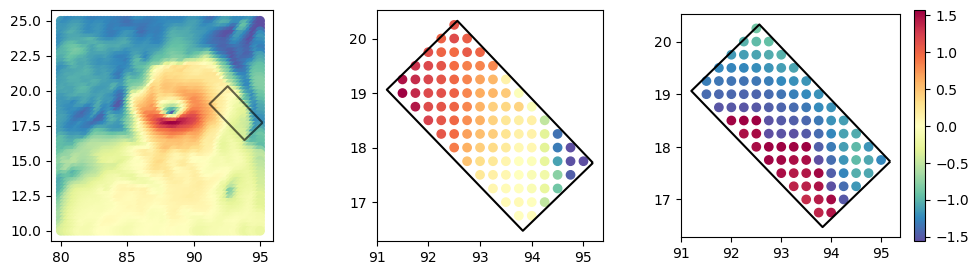

In [48]:
# define aoi
aoi = geospatial_utils.create_aoi(centroid, height, width, rotation=rotation, local_crs=local_crs)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
ax = axs[0]
df_wind.to_crs(4326).plot('speed', ax=ax, cmap='Spectral_r')
aoi.to_crs(4326).boundary.plot(color='k', ax=ax, alpha=.6, zorder=10)

df_aoi = gpd.overlay(df_wind, aoi, how='intersection')

ax = axs[1]
aoi.to_crs(4326).boundary.plot(color='k', ax=ax, cmap='Spectral_r')
df_aoi.to_crs(4326).plot('speed', ax=ax, cmap='Spectral_r')

ax = axs[2]
aoi.to_crs(4326).boundary.plot(color='k', ax=ax, cmap='Spectral_r')
df_aoi.to_crs(4326).plot('direction', ax=ax, cmap='Spectral_r', legend=True)

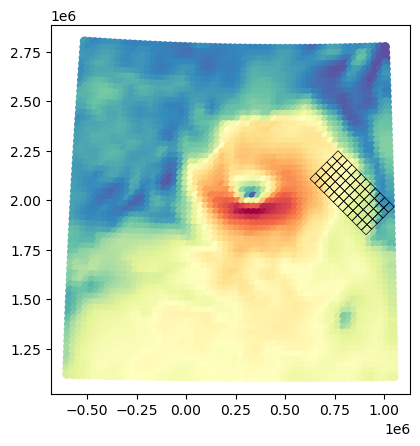

In [49]:
# define grid
grid, _ = geospatial_utils.create_aoi_grid(centroid, mesh=mesh, height=height, width=width,
                                           rotation=rotation, local_crs=local_crs)

fig, ax = plt.subplots()
df_wind.plot('speed', ax=ax, cmap='Spectral_r')
grid.boundary.plot(color='k', linewidth=.5, ax=ax, zorder=10);

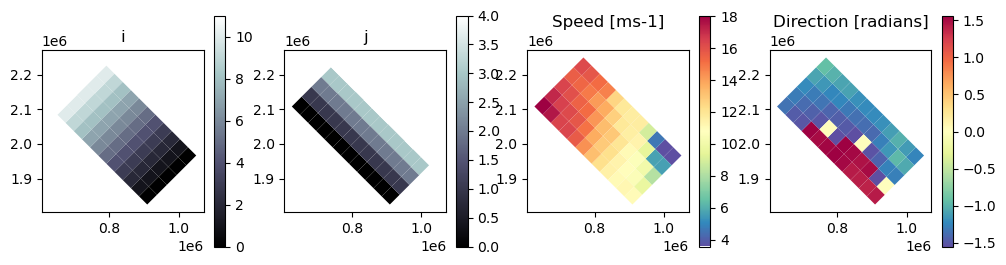

In [50]:
grid, index = geospatial_utils.create_aoi_grid(centroid, mesh=mesh, height=height, width=width,
                                               rotation=rotation, local_crs=local_crs)
wind_grid = geospatial_utils.grid_zonal_statistics(grid, index, df_wind, local_crs, ['speed', 'direction'])

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
wind_grid.plot('i', legend=True, ax=axs[0], cmap='bone')
wind_grid.plot('j', legend=True, ax=axs[1], cmap='bone')
wind_grid.plot('speed', legend=True, ax=axs[2], cmap='Spectral_r')
wind_grid.plot('direction', legend=True, ax=axs[3], cmap='Spectral_r')

axs[0].set_title('i')
axs[1].set_title('j');
axs[2].set_title('Speed [ms-1]')
axs[3].set_title('Direction [radians]');

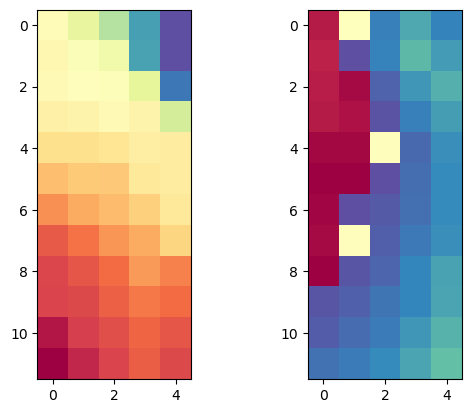

In [51]:
# finally, make it a numpy matrix where (0, 0)->(ny,nx) is causality
speedmat = geospatial_utils.grid_gdf_to_numpy(wind_grid, 'speed')
dirmat = geospatial_utils.grid_gdf_to_numpy(wind_grid, 'direction')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(speedmat, cmap='Spectral_r')
axs[1].imshow(dirmat, cmap='Spectral_r')

In [52]:
metadata = {"centroid": centroid, "height": height, "width": width, "rotation": rotation,
            "crs": local_crs, "mesh": mesh}

np.savez(os.path.join(outdir, 'speed.npz'), array=speedmat, **metadata)
np.savez(os.path.join(outdir, 'direction.npz'), array=dirmat, **metadata)
speedz = np.load(os.path.join(outdir, 'speed.npz'))
speedz.files

['array', 'centroid', 'height', 'width', 'rotation', 'crs', 'mesh']

{'centroid': [93.2, 18.4], 'height': 400000, 'width': 200000, 'rotation': 45, 'crs': 3106, 'mesh': 30000}


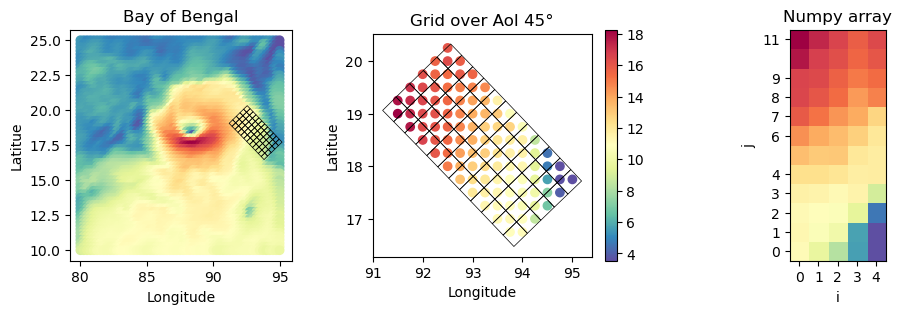

In [53]:
# plot for README
grid, index = geospatial_utils.create_aoi_grid(centroid, mesh=mesh, height=height, width=width,
                                           rotation=rotation, local_crs=local_crs)

i = [x[0] for x in index]
j = [x[1] for x in index]

grid = gpd.GeoDataFrame(geometry=grid).set_crs(local_crs)
aoi = gpd.GeoDataFrame(geometry=[grid.unary_union]).set_crs(local_crs)
df_aoi = gpd.overlay(df_wind, aoi, how='intersection')


fig, axs = plt.subplots(1, 3, figsize=(12, 3))

ax = axs[0]
df_wind.to_crs(4326).plot('speed', ax=ax, cmap='Spectral_r')
grid.to_crs(4326).boundary.plot(color='k', linewidth=.5, ax=ax, zorder=10);
ax.set_title('Bay of Bengal')
ax.set_xlabel('Longitude'), ax.set_ylabel('Latitue')

ax = axs[1]
df_aoi.to_crs(4326).plot('speed', ax=ax, cmap='Spectral_r', legend=True)
grid.to_crs(4326).boundary.plot(color='k', ax=ax, cmap='Spectral_r', linewidth=.5);
ax.set_title(f'Grid over AoI {rotation}\N{DEGREE SIGN}')
ax.set_xlabel('Longitude'), ax.set_ylabel('Latitue')

ax = axs[2]
ax.imshow(speedmat, cmap="Spectral_r");
ax.set_xlabel('i')
ax.set_ylabel('j')
ax.set_yticks(np.linspace(min(i), max(i), max(i) - 1, dtype=int))
ax.set_title('Numpy array')
            
ax.set_xticks(np.linspace(min(j), max(j), 5))
ax.set_ylim(ax.get_ylim()[::-1]);

fig.savefig(os.path.join(datadir, f'example{rotation}.png'), bbox_inches='tight', dpi=300)
print(metadata)

# Bathymetry (do the same)

In [11]:
df_bathy = geospatial_utils.xarray_to_geopandas(bathypath, xvar='lon', yvar='lat', var=['elevation'])
df_bathy = df_bathy.to_crs(local_crs)
bathy_grid = geospatial_utils.grid_zonal_statistics(grid, index, df_bathy, local_crs, ['elevation'])

if False: # takes a long time because bigger file
    fig, ax = plt.subplots()
    df_bathy.plot('elevation', ax=ax, cmap='terrain')
    grid.boundary.plot(color='k', linewidth=.5, ax=ax, zorder=10);
    !say done

Text(0.5, 1.0, 'Elevation [m]')

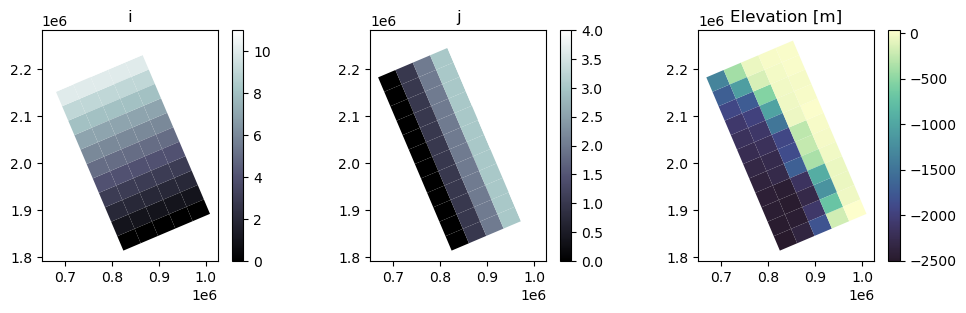

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
bathy_grid.plot('i', legend=True, ax=axs[0], cmap='bone')
bathy_grid.plot('j', legend=True, ax=axs[1], cmap='bone')
bathy_grid.plot('elevation', legend=True, ax=axs[2], cmap=cmo.deep_r)

axs[0].set_title('i')
axs[1].set_title('j');
axs[2].set_title('Elevation [m]')

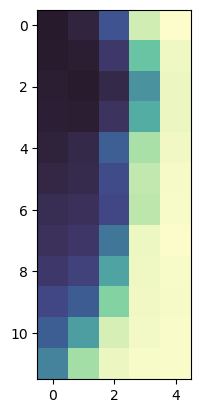

In [13]:
# finally, make it a numpy matrix where (0, 0)->(ny,nx) is causality
bathymat = -geospatial_utils.grid_gdf_to_numpy(bathy_grid, 'elevation')

fig, ax = plt.subplots()
im = ax.imshow(bathymat, cmap=cmo.deep)

In [14]:
np.savez(os.path.join(outdir, 'bathymetry.npz'), array=bathymat, **metadata)

# Inverse transform

<Axes: >

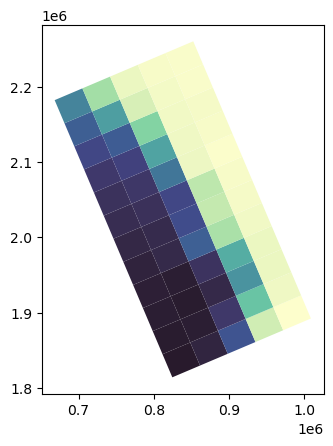

In [15]:
bathy_file = np.load(os.path.join(outdir, 'bathymetry.npz'))
gdf = geospatial_utils.npz_to_gdf_grid(bathy_file, "bathymetry")
gdf.plot("bathymetry", cmap=cmo.deep)